# ViT CIFAR-10
load timm ViT and retrain on CIFAR 10

In [1]:
NOQUANT_TRAIN = False

In [2]:
import argparse
import os
import shutil
import time
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import time
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

DATA_DIR = "train"
print_freq = 50

# vit imsize
imsize = 224

In [3]:
# prepare labels
train_df = pd.read_csv("trainLabels.csv")
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df['label_enc'] = le.fit_transform(train_df['label'])

# 5-fold
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_df["fold"] = -1
for i, (train_index, test_index) in enumerate(skf.split(train_df.id, train_df.label_enc)):
    train_df.loc[test_index, 'fold'] = i
train_df.head()

,id,label,label_enc,fold
0,1,frog,6,1
1,2,truck,9,1
2,3,truck,9,2
3,4,deer,4,1
4,5,automobile,1,2


In [4]:
class cifarDataset(Dataset):
    def __init__(self,
                 df,
                 rand=False,
                 transform=None,
                 test=False
                ):

        self.df = df.reset_index(drop=True)
        self.rand = rand
        self.transform = transform
        self.test = test

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.id
        
        images = cv2.imread(os.path.join(DATA_DIR, str(img_id)+".png"))
        
        # Load labels
        label = row.label_enc
        
        # aug
        if self.transform is not None:
            images = self.transform(image=images)['image']
              
        #images = images.astype(np.float32)
        #images /= 255
        images = images.transpose(2, 0, 1)
        
        label = label.astype(np.float32)
        #label2 = label2.astype(np.float32)
        return torch.tensor(images), torch.tensor(label),

In [5]:
import albumentations as A
import albumentations

transforms_train = albumentations.Compose([
    albumentations.ShiftScaleRotate(scale_limit=0.3, rotate_limit=180,p=0.5),
    A.Cutout(num_holes=12, max_h_size=4, max_w_size=4, fill_value=0, p=0.5),
    #albumentations.Rotate(p=0.5),
    #albumentations.Transpose(p=0.5),
    #albumentations.VerticalFlip(p=0.5),
    albumentations.HorizontalFlip(p=0.5),   
    albumentations.Resize(imsize, imsize, p=1.0), 
    albumentations.Normalize(mean=(0.485, 0.456, 0.406),
                       std=(0.229, 0.224, 0.225), p=1),
])

transforms_val = albumentations.Compose([albumentations.Resize(imsize, imsize, p=1.0),
                                         albumentations.Normalize(mean=(0.485, 0.456, 0.406),
                       std=(0.229, 0.224, 0.225), p=1),])

/home/ken/anaconda3/envs/pytorch_p38_2/lib/python3.8/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

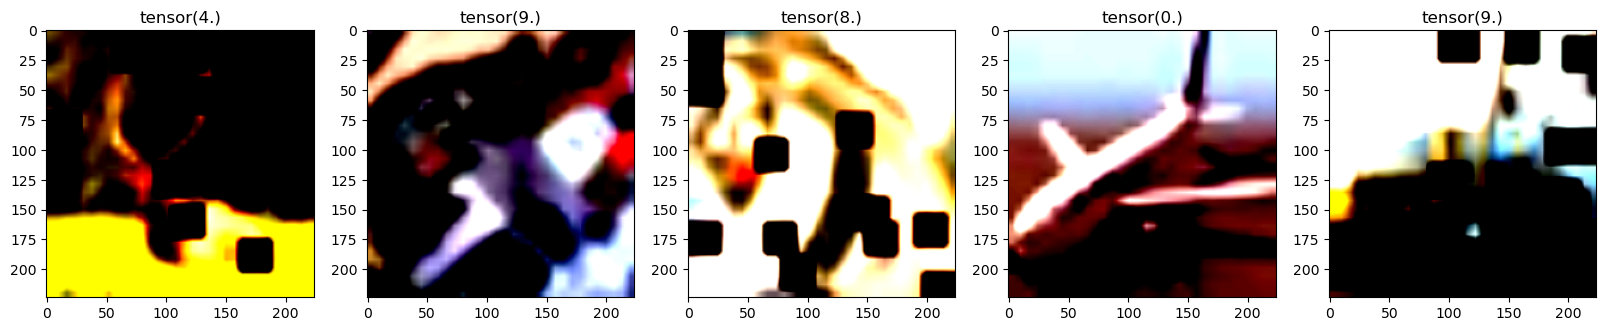

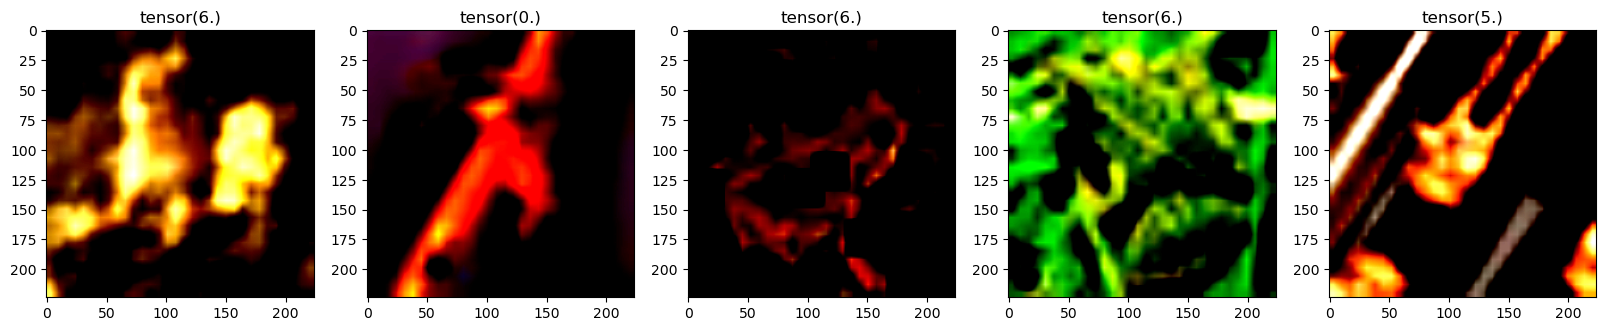

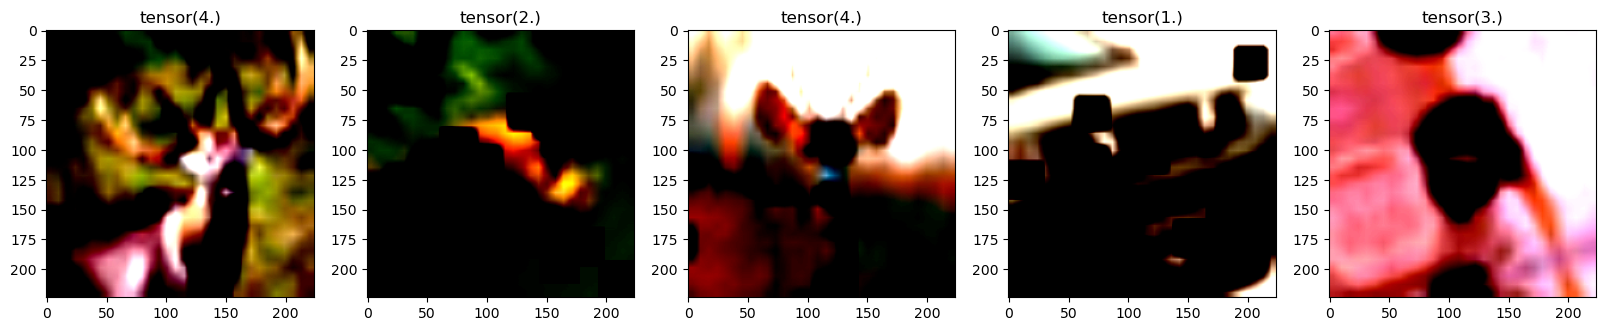

In [6]:
dataset_show = cifarDataset(train_df, transform=transforms_train)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(3):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        img = img.flip(0) #BGR2RGB
        axarr[p].imshow(img.transpose(0,1).transpose(1,2))
        axarr[p].set_title(str(label))
plt.show()

In [7]:
def train(train_loader, model, criterion, optimizer, epoch):
    """
        Run one train epoch
    """
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    lambda_alpha = 0.002
    for i, (input, target) in enumerate(tqdm(train_loader)):

        # measure data loading time
        data_time.update(time.time() - end)
        target2 = target

        target = target.long().cuda()
        target2 = target2.long().cuda()
        input_var = input.cuda()
        target_var = target

        if not mixup:
          alpha = 0
        else:
          alpha = 1
        

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # L2 regularization
        l2_alpha = 0.0
        for name, param in model.named_parameters():
            if "alpha" in name:
                l2_alpha += torch.pow(param, 2)
        loss += lambda_alpha * l2_alpha

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        output = output.float()
        loss = loss.float()
        # measure accuracy and record loss
        prec1 = accuracy(output.data, target)[0]
        losses.update(loss.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                      epoch, i, len(train_loader), batch_time=batch_time,
                      data_time=data_time, loss=losses, top1=top1))
    return losses.avg

def validate(val_loader, model, criterion):
    """
    Run evaluation
    """
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            target = target.long().cuda()
            input_var = input.cuda()
            target_var = target.cuda()

            # compute output
            output = model(input_var)
            loss = criterion(output, target_var)

            output = output.float()
            loss = loss.float()

            # measure accuracy and record loss
            prec1 = accuracy(output.data, target)[0]
            losses.update(loss.item(), input.size(0))
            top1.update(prec1.item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % print_freq == 0:
                print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                          i, len(val_loader), batch_time=batch_time, loss=losses,
                          top1=top1))

    print(' * Prec@1 {top1.avg:.3f}'
          .format(top1=top1))
    for name, param in model.named_parameters():
        if "alpha" in name:
            print(name, param.item())
    return top1.avg, losses.avg

def save_checkpoint(state, filename='checkpoint.pth'):
    """
    Save the training model
    """
    torch.save(state, filename)

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [8]:
train_dataset = cifarDataset(train_df[train_df.fold!=0], transform=transforms_train)
val_dataset = cifarDataset(train_df[train_df.fold==0], transform=transforms_val, test=True)

train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=256, shuffle=True,
        num_workers=8, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=512, shuffle=False,
    num_workers=8, pin_memory=True)

# Train VIT without quantization

In [9]:
if NOQUANT_TRAIN:
    import timm
    net = timm.create_model("vit_base_patch16_224", pretrained=True)
    net.head = nn.Linear(net.head.in_features, 10)
    model = net.cuda()
    mixup = False

    import wandb
    watermark = "vit_base_noquant"
    wandb.init(project="pact_vit",
                name=watermark)

    # define loss function (criterion) and pptimizer
    criterion = nn.CrossEntropyLoss().cuda()

    #optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3,
                                momentum=0.9,
                                weight_decay=0.0002)

    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, 
                                                        milestones=[80, 150],)

    best_prec1 = 0
    os.makedirs("models", exist_ok=True)
    for epoch in range(10):
        # train for one epoch
        print('current lr {:.5e}'.format(optimizer.param_groups[0]['lr']))
        tloss = train(train_loader, model, criterion, optimizer, epoch)
        lr_scheduler.step()

        # evaluate on validation set
        prec1, valloss = validate(val_loader, model, criterion)

        # wandb
        wandb.log({'epoch': epoch, "prec":prec1, "train_loss": tloss, 'val_loss': valloss, "lr": optimizer.param_groups[0]["lr"],})

        # remember best prec@1 and save checkpoint
        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)

        print("Best prec1 : ", best_prec1)
        if is_best:
            torch.save(model.state_dict(), os.path.join(f'models/{watermark}.pth'))

# Train with quantization

In [10]:
from module import ActFn

# For activation quantization
class Activation(nn.Module):
    def __init__(self, k):
        super().__init__()
        self.ActFn = ActFn.apply
        self.k = k
        self.alpha = nn.Parameter(torch.tensor(10.))
    
    def forward(self, x):
        return self.ActFn(x, self.alpha, self.k)

In [11]:
# have fun with timm models

from timm.models.layers import Mlp, DropPath, trunc_normal_, lecun_normal_
from timm.models.registry import register_model
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD, IMAGENET_INCEPTION_MEAN, IMAGENET_INCEPTION_STD
from timm.models.helpers import build_model_with_cfg, named_apply, adapt_input_conv
from functools import partial
from pact_utils import QuantizedLinear, TorchQuantize, QuantizedConv2d

from timm.models.layers.helpers import to_2tuple
from timm.models.layers.trace_utils import _assert


class PatchEmbed(nn.Module):
    """ 2D Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768, norm_layer=None, flatten=True, wbits=8, abits=8):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = (img_size[0] // patch_size[0], img_size[1] // patch_size[1])
        self.num_patches = self.grid_size[0] * self.grid_size[1]
        self.flatten = flatten

        self.proj = QuantizedConv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size, wbits=wbits, abits=abits)
        self.norm = norm_layer(embed_dim) if norm_layer else nn.Identity()

    def forward(self, x):
        B, C, H, W = x.shape
        _assert(H == self.img_size[0], f"Input image height ({H}) doesn't match model ({self.img_size[0]}).")
        _assert(W == self.img_size[1], f"Input image width ({W}) doesn't match model ({self.img_size[1]}).")
        x = self.proj(x)
        if self.flatten:
            x = x.flatten(2).transpose(1, 2)  # BCHW -> BNC
        x = self.norm(x)
        return x

class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0., wk=8, ik=8, pact=False, noise=0):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = QuantizedLinear(in_features, hidden_features, True, wk, ik, pact, noise, half=True)
        self.act = act_layer()
        self.fc2 = QuantizedLinear(hidden_features, out_features, True, wk, ik, pact, noise, half=True)
        self.drop = nn.Dropout(drop)
        
        # PACT
        self.k = ik
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0., wk=8, ik=8, pact=False, noise=0):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = QuantizedLinear(dim, dim * 3, qkv_bias, wk, ik, pact, noise)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = QuantizedLinear(dim, dim, True, wk, ik, pact, noise)
        self.proj_drop = nn.Dropout(proj_drop)
        self.quantize = TorchQuantize(ik)
        
        # PACT
        self.k = ik

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)

        attn = (self.quantize(q) @ self.quantize(k.transpose(-2, -1))) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (self.quantize(attn) @ self.quantize(v)).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm, wk=8, ik=8, pact=False, attenkw=5, attenki=5, noise=0):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop, wk=attenkw, ik=attenki, pact=pact, noise=noise)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop, wk=wk, ik=ik, noise=noise)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class VisionTransformer(nn.Module):
    """ Vision Transformer
    A PyTorch impl of : `An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale`
        - https://arxiv.org/abs/2010.11929
    Includes distillation token & head support for `DeiT: Data-efficient Image Transformers`
        - https://arxiv.org/abs/2012.12877
    """

    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dim=768, depth=12,
                 num_heads=12, mlp_ratio=4., qkv_bias=True, representation_size=None, distilled=False,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0., embed_layer=PatchEmbed, norm_layer=None,
                 act_layer=None, weight_init='', wk=8, ik=8, pact=False, attenkw=5, attenki=5, noise=0):
        """
        Args:
            img_size (int, tuple): input image size
            patch_size (int, tuple): patch size
            in_chans (int): number of input channels
            num_classes (int): number of classes for classification head
            embed_dim (int): embedding dimension
            depth (int): depth of transformer
            num_heads (int): number of attention heads
            mlp_ratio (int): ratio of mlp hidden dim to embedding dim
            qkv_bias (bool): enable bias for qkv if True
            representation_size (Optional[int]): enable and set representation layer (pre-logits) to this value if set
            distilled (bool): model includes a distillation token and head as in DeiT models
            drop_rate (float): dropout rate
            attn_drop_rate (float): attention dropout rate
            drop_path_rate (float): stochastic depth rate
            embed_layer (nn.Module): patch embedding layer
            norm_layer: (nn.Module): normalization layer
            weight_init: (str): weight init scheme
        """
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        self.num_tokens = 2 if distilled else 1
        norm_layer = norm_layer or partial(nn.LayerNorm, eps=1e-6)
        act_layer = act_layer or nn.GELU

        self.patch_embed = embed_layer(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim, abits=8, wbits=8)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.dist_token = nn.Parameter(torch.zeros(1, 1, embed_dim)) if distilled else None
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + self.num_tokens, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.Sequential(*[
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, drop=drop_rate,
                attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer, act_layer=act_layer, wk=wk, ik=ik, pact=pact, 
                attenkw=attenkw, attenki=attenki, noise=noise)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)

        # Representation layer
        if representation_size and not distilled:
            self.num_features = representation_size
            self.pre_logits = nn.Sequential(OrderedDict([
                ('fc', nn.Linear(embed_dim, representation_size)),
                ('act', nn.Tanh())
            ]))
        else:
            self.pre_logits = nn.Identity()

        # Classifier head(s)
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()
        self.head_dist = None
        if distilled:
            self.head_dist = nn.Linear(self.embed_dim, self.num_classes) if num_classes > 0 else nn.Identity()

        self.init_weights(weight_init)

    def init_weights(self, mode=''):
        assert mode in ('jax', 'jax_nlhb', 'nlhb', '')
        head_bias = -math.log(self.num_classes) if 'nlhb' in mode else 0.
        trunc_normal_(self.pos_embed, std=.02)
        if self.dist_token is not None:
            trunc_normal_(self.dist_token, std=.02)
        if mode.startswith('jax'):
            # leave cls token as zeros to match jax impl
            named_apply(partial(_init_vit_weights, head_bias=head_bias, jax_impl=True), self)
        else:
            trunc_normal_(self.cls_token, std=.02)
            self.apply(_init_vit_weights)

    def _init_weights(self, m):
        # this fn left here for compat with downstream users
        _init_vit_weights(m)

    @torch.jit.ignore()
    def load_pretrained(self, checkpoint_path, prefix=''):
        _load_weights(self, checkpoint_path, prefix)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token', 'dist_token'}

    def get_classifier(self):
        if self.dist_token is None:
            return self.head
        else:
            return self.head, self.head_dist

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()
        if self.num_tokens == 2:
            self.head_dist = nn.Linear(self.embed_dim, self.num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        x = self.patch_embed(x)
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        if self.dist_token is None:
            x = torch.cat((cls_token, x), dim=1)
        else:
            x = torch.cat((cls_token, self.dist_token.expand(x.shape[0], -1, -1), x), dim=1)
        x = self.pos_drop(x + self.pos_embed)
        x = self.blocks(x)
        x = self.norm(x)
        if self.dist_token is None:
            return self.pre_logits(x[:, 0])
        else:
            return x[:, 0], x[:, 1]

    def forward(self, x):
        x = self.forward_features(x)
        if self.head_dist is not None:
            x, x_dist = self.head(x[0]), self.head_dist(x[1])  # x must be a tuple
            if self.training and not torch.jit.is_scripting():
                # during inference, return the average of both classifier predictions
                return x, x_dist
            else:
                return (x + x_dist) / 2
        else:
            x = self.head(x)
        return x


def _init_vit_weights(module: nn.Module, name: str = '', head_bias: float = 0., jax_impl: bool = False):
    """ ViT weight initialization
    * When called without n, head_bias, jax_impl args it will behave exactly the same
      as my original init for compatibility with prev hparam / downstream use cases (ie DeiT).
    * When called w/ valid n (module name) and jax_impl=True, will (hopefully) match JAX impl
    """
    if isinstance(module, nn.Linear):
        if name.startswith('head'):
            nn.init.zeros_(module.weight)
            nn.init.constant_(module.bias, head_bias)
        elif name.startswith('pre_logits'):
            lecun_normal_(module.weight)
            nn.init.zeros_(module.bias)
        else:
            if jax_impl:
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    if 'mlp' in name:
                        nn.init.normal_(module.bias, std=1e-6)
                    else:
                        nn.init.zeros_(module.bias)
            else:
                trunc_normal_(module.weight, std=.02)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
    elif jax_impl and isinstance(module, nn.Conv2d):
        # NOTE conv was left to pytorch default in my original init
        lecun_normal_(module.weight)
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    elif isinstance(module, (nn.LayerNorm, nn.GroupNorm, nn.BatchNorm2d)):
        nn.init.zeros_(module.bias)
        nn.init.ones_(module.weight)


@torch.no_grad()
def _load_weights(model: VisionTransformer, checkpoint_path: str, prefix: str = ''):
    """ Load weights from .npz checkpoints for official Google Brain Flax implementation
    """
    import numpy as np

    def _n2p(w, t=True):
        if w.ndim == 4 and w.shape[0] == w.shape[1] == w.shape[2] == 1:
            w = w.flatten()
        if t:
            if w.ndim == 4:
                w = w.transpose([3, 2, 0, 1])
            elif w.ndim == 3:
                w = w.transpose([2, 0, 1])
            elif w.ndim == 2:
                w = w.transpose([1, 0])
        return torch.from_numpy(w)

    w = np.load(checkpoint_path)
    if not prefix and 'opt/target/embedding/kernel' in w:
        prefix = 'opt/target/'

    if hasattr(model.patch_embed, 'backbone'):
        # hybrid
        backbone = model.patch_embed.backbone
        stem_only = not hasattr(backbone, 'stem')
        stem = backbone if stem_only else backbone.stem
        stem.conv.weight.copy_(adapt_input_conv(stem.conv.weight.shape[1], _n2p(w[f'{prefix}conv_root/kernel'])))
        stem.norm.weight.copy_(_n2p(w[f'{prefix}gn_root/scale']))
        stem.norm.bias.copy_(_n2p(w[f'{prefix}gn_root/bias']))
        if not stem_only:
            for i, stage in enumerate(backbone.stages):
                for j, block in enumerate(stage.blocks):
                    bp = f'{prefix}block{i + 1}/unit{j + 1}/'
                    for r in range(3):
                        getattr(block, f'conv{r + 1}').weight.copy_(_n2p(w[f'{bp}conv{r + 1}/kernel']))
                        getattr(block, f'norm{r + 1}').weight.copy_(_n2p(w[f'{bp}gn{r + 1}/scale']))
                        getattr(block, f'norm{r + 1}').bias.copy_(_n2p(w[f'{bp}gn{r + 1}/bias']))
                    if block.downsample is not None:
                        block.downsample.conv.weight.copy_(_n2p(w[f'{bp}conv_proj/kernel']))
                        block.downsample.norm.weight.copy_(_n2p(w[f'{bp}gn_proj/scale']))
                        block.downsample.norm.bias.copy_(_n2p(w[f'{bp}gn_proj/bias']))
        embed_conv_w = _n2p(w[f'{prefix}embedding/kernel'])
    else:
        embed_conv_w = adapt_input_conv(
            model.patch_embed.proj.weight.shape[1], _n2p(w[f'{prefix}embedding/kernel']))
    model.patch_embed.proj.weight.copy_(embed_conv_w)
    model.patch_embed.proj.bias.copy_(_n2p(w[f'{prefix}embedding/bias']))
    model.cls_token.copy_(_n2p(w[f'{prefix}cls'], t=False))
    pos_embed_w = _n2p(w[f'{prefix}Transformer/posembed_input/pos_embedding'], t=False)
    if pos_embed_w.shape != model.pos_embed.shape:
        pos_embed_w = resize_pos_embed(  # resize pos embedding when different size from pretrained weights
            pos_embed_w, model.pos_embed, getattr(model, 'num_tokens', 1), model.patch_embed.grid_size)
    model.pos_embed.copy_(pos_embed_w)
    model.norm.weight.copy_(_n2p(w[f'{prefix}Transformer/encoder_norm/scale']))
    model.norm.bias.copy_(_n2p(w[f'{prefix}Transformer/encoder_norm/bias']))
    if isinstance(model.head, nn.Linear) and model.head.bias.shape[0] == w[f'{prefix}head/bias'].shape[-1]:
        model.head.weight.copy_(_n2p(w[f'{prefix}head/kernel']))
        model.head.bias.copy_(_n2p(w[f'{prefix}head/bias']))
    if isinstance(getattr(model.pre_logits, 'fc', None), nn.Linear) and f'{prefix}pre_logits/bias' in w:
        model.pre_logits.fc.weight.copy_(_n2p(w[f'{prefix}pre_logits/kernel']))
        model.pre_logits.fc.bias.copy_(_n2p(w[f'{prefix}pre_logits/bias']))
    for i, block in enumerate(model.blocks.children()):
        block_prefix = f'{prefix}Transformer/encoderblock_{i}/'
        mha_prefix = block_prefix + 'MultiHeadDotProductAttention_1/'
        block.norm1.weight.copy_(_n2p(w[f'{block_prefix}LayerNorm_0/scale']))
        block.norm1.bias.copy_(_n2p(w[f'{block_prefix}LayerNorm_0/bias']))
        block.attn.qkv.weight.copy_(torch.cat([
            _n2p(w[f'{mha_prefix}{n}/kernel'], t=False).flatten(1).T for n in ('query', 'key', 'value')]))
        block.attn.qkv.bias.copy_(torch.cat([
            _n2p(w[f'{mha_prefix}{n}/bias'], t=False).reshape(-1) for n in ('query', 'key', 'value')]))
        block.attn.proj.weight.copy_(_n2p(w[f'{mha_prefix}out/kernel']).flatten(1))
        block.attn.proj.bias.copy_(_n2p(w[f'{mha_prefix}out/bias']))
        for r in range(2):
            getattr(block.mlp, f'fc{r + 1}').weight.copy_(_n2p(w[f'{block_prefix}MlpBlock_3/Dense_{r}/kernel']))
            getattr(block.mlp, f'fc{r + 1}').bias.copy_(_n2p(w[f'{block_prefix}MlpBlock_3/Dense_{r}/bias']))
        block.norm2.weight.copy_(_n2p(w[f'{block_prefix}LayerNorm_2/scale']))
        block.norm2.bias.copy_(_n2p(w[f'{block_prefix}LayerNorm_2/bias']))


def resize_pos_embed(posemb, posemb_new, num_tokens=1, gs_new=()):
    # Rescale the grid of position embeddings when loading from state_dict. Adapted from
    # https://github.com/google-research/vision_transformer/blob/00883dd691c63a6830751563748663526e811cee/vit_jax/checkpoint.py#L224
    _logger.info('Resized position embedding: %s to %s', posemb.shape, posemb_new.shape)
    ntok_new = posemb_new.shape[1]
    if num_tokens:
        posemb_tok, posemb_grid = posemb[:, :num_tokens], posemb[0, num_tokens:]
        ntok_new -= num_tokens
    else:
        posemb_tok, posemb_grid = posemb[:, :0], posemb[0]
    gs_old = int(math.sqrt(len(posemb_grid)))
    if not len(gs_new):  # backwards compatibility
        gs_new = [int(math.sqrt(ntok_new))] * 2
    assert len(gs_new) >= 2
    _logger.info('Position embedding grid-size from %s to %s', [gs_old, gs_old], gs_new)
    posemb_grid = posemb_grid.reshape(1, gs_old, gs_old, -1).permute(0, 3, 1, 2)
    posemb_grid = F.interpolate(posemb_grid, size=gs_new, mode='bicubic', align_corners=False)
    posemb_grid = posemb_grid.permute(0, 2, 3, 1).reshape(1, gs_new[0] * gs_new[1], -1)
    posemb = torch.cat([posemb_tok, posemb_grid], dim=1)
    return posemb


def checkpoint_filter_fn(state_dict, model):
    """ convert patch embedding weight from manual patchify + linear proj to conv"""
    out_dict = {}
    if 'model' in state_dict:
        # For deit models
        state_dict = state_dict['model']
    for k, v in state_dict.items():
        if 'patch_embed.proj.weight' in k and len(v.shape) < 4:
            # For old models that I trained prior to conv based patchification
            O, I, H, W = model.patch_embed.proj.weight.shape
            v = v.reshape(O, -1, H, W)
        elif k == 'pos_embed' and v.shape != model.pos_embed.shape:
            # To resize pos embedding when using model at different size from pretrained weights
            v = resize_pos_embed(
                v, model.pos_embed, getattr(model, 'num_tokens', 1), model.patch_embed.grid_size)
        out_dict[k] = v
    return out_dict


def _create_vision_transformer(variant, pretrained=False, default_cfg=None, **kwargs):
    default_cfg = default_cfg or default_cfgs[variant]
    if kwargs.get('features_only', None):
        raise RuntimeError('features_only not implemented for Vision Transformer models.')

    # NOTE this extra code to support handling of repr size for in21k pretrained models
    default_num_classes = default_cfg['num_classes']
    num_classes = kwargs.get('num_classes', default_num_classes)
    repr_size = kwargs.pop('representation_size', None)
    if repr_size is not None and num_classes != default_num_classes:
        # Remove representation layer if fine-tuning. This may not always be the desired action,
        # but I feel better than doing nothing by default for fine-tuning. Perhaps a better interface?
        _logger.warning("Removing representation layer for fine-tuning.")
        repr_size = None

    model = build_model_with_cfg(
        VisionTransformer, variant, pretrained,
        default_cfg=default_cfg,
        representation_size=repr_size,
        pretrained_filter_fn=checkpoint_filter_fn,
        pretrained_custom_load='npz' in default_cfg['url'],
        **kwargs)
    return model

def _cfg(url='', **kwargs):
    return {
        'url': url,
        'num_classes': 1000, 'input_size': (3, 224, 224), 'pool_size': None,
        'crop_pct': .9, 'interpolation': 'bicubic', 'fixed_input_size': True,
        'mean': IMAGENET_INCEPTION_MEAN, 'std': IMAGENET_INCEPTION_STD,
        'first_conv': 'patch_embed.proj', 'classifier': 'head',
        **kwargs
    }

default_cfgs = {
    # patch models (weights from official Google JAX impl)
    'vit_tiny_patch16_224': _cfg(
        url='https://storage.googleapis.com/vit_models/augreg/'
            'Ti_16-i21k-300ep-lr_0.001-aug_none-wd_0.03-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_224.npz'),
    'vit_small_patch16_224': _cfg(
        url='https://storage.googleapis.com/vit_models/augreg/'
            'S_16-i21k-300ep-lr_0.001-aug_light1-wd_0.03-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_224.npz'),
    }

@register_model
def vit_tiny_patch16_224(pretrained=False, k=8, pact=False, **kwargs):
    """ ViT-Tiny (Vit-Ti/16)
    """
    model_kwargs = dict(patch_size=16, embed_dim=192, depth=12, num_heads=3, k=k, pact=pact, **kwargs)
    model = _create_vision_transformer('vit_tiny_patch16_224', pretrained=pretrained, **model_kwargs)
    return model

@register_model
def vit_small_patch16_224(pretrained=False, k=8, **kwargs):
    """ ViT-Small (ViT-S/16)
    NOTE I've replaced my previous 'small' model definition and weights with the small variant from the DeiT paper
    """
    model_kwargs = dict(patch_size=16, embed_dim=384, depth=12, num_heads=6, k=k, **kwargs)
    model = _create_vision_transformer('vit_small_patch16_224', pretrained=pretrained, **model_kwargs)
    return model

@register_model
def vit_base_patch16_224(pretrained=False, **kwargs):
    """ ViT-Base (ViT-B/16) from original paper (https://arxiv.org/abs/2010.11929).
    ImageNet-1k weights fine-tuned from in21k @ 224x224, source https://github.com/google-research/vision_transformer.
    """
    model_kwargs = dict(patch_size=16, embed_dim=768, depth=12, num_heads=12, **kwargs)
    model = _create_vision_transformer('vit_base_patch16_224', pretrained=pretrained, **model_kwargs)
    return model

In [12]:
def get_vit(modelname, wk, ik, attenkw, attenki, noise):
    if modelname=="tiny":
        net = VisionTransformer(patch_size=16, embed_dim=192, depth=12, num_heads=3, wk=wk, ik=ik, attenkw=attenkw, attenki=attenki, noise=noise)
        net.head = nn.Linear(net.head.in_features, 10)
        checkpoint = torch.load("models/vit_tiny_wk6_ik6_attenkw6_attenki6_noise0_nopact.pth")
       
    else:
        net = VisionTransformer(patch_size=16, embed_dim=384, depth=12, num_heads=6, wk=wk, ik=ik, attenkw=attenkw, attenki=attenki, noise=noise)
        net.head = nn.Linear(net.head.in_features, 10)
        checkpoint = torch.load("models/vit_small_noquant.pth")
    
    net.load_state_dict(checkpoint)
    model = net.cuda()
    return model

In [ ]:
from timm.scheduler import CosineLRScheduler

noise=0
PACT = False
mixup = False

for modelname in ["tiny", ]:
    for attenkw in [4]:
        for attenki in [4]:
            for wk in [6,]:
                for ik in [6]:
                    
                    # get model
                    model = get_vit(modelname, wk, ik, attenkw, attenki, noise)

                    # Track experiment with wandb
                    import wandb
                    watermark = "vit_{}_wk{}_ik{}_attenkw{}_attenki{}_noise{}".format(modelname, wk, ik, attenkw, attenki, noise)
                    if PACT == False:
                        watermark+="_nopact"
                    else:
                        watermark+="_pact"

                    # mess with wandb
                    wandb.init(project="pact_vit_20220728", name=watermark)

                    # define loss function (criterion) and pptimizer
                    criterion = nn.CrossEntropyLoss().cuda()

                    # optimizer for pact
                    optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

                    scheduler = CosineLRScheduler(optimizer, t_initial=40, lr_min=1e-6, 
                                          warmup_t=3, warmup_lr_init=1e-5, warmup_prefix=True)

                    best_prec1 = 0
                    os.makedirs("models", exist_ok=True)

                    for epoch in range(40):
                        scheduler.step(epoch)
                        # train for one epoch
                        print('current lr {:.5e}'.format(optimizer.param_groups[0]['lr']))
                        tloss = train(train_loader, model, criterion, optimizer, epoch)         

                        # evaluate on validation set
                        prec1, valloss = validate(val_loader, model, criterion)

                        # wandb
                        wandb.log({'epoch': epoch, "prec":prec1, "train_loss": tloss, 'val_loss': valloss, "lr": optimizer.param_groups[0]["lr"],})

                        # remember best prec@1 and save checkpoint
                        is_best = prec1 > best_prec1
                        best_prec1 = max(prec1, best_prec1)

                        print("Best prec1 : ", best_prec1)
                        if is_best:
                            torch.save(model.state_dict(), os.path.join(f'models/{watermark}.pth'))
                        if prec1<50:
                            break


wandb: Currently logged in as: arutema47 (keio-csg). Use `wandb login --relogin` to force relogin


current lr 1.00000e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [0][0/157]	Time 3.404 (3.404)	Data 1.052 (1.052)	Loss 2.4770 (2.4770)	Prec@1 21.484 (21.484)
Epoch: [0][50/157]	Time 0.682 (0.733)	Data 0.001 (0.022)	Loss 1.1144 (1.4527)	Prec@1 61.719 (49.426)
Epoch: [0][100/157]	Time 0.683 (0.707)	Data 0.001 (0.012)	Loss 0.8603 (1.2129)	Prec@1 69.141 (58.010)
Epoch: [0][150/157]	Time 0.684 (0.699)	Data 0.001 (0.008)	Loss 0.6943 (1.0833)	Prec@1 76.953 (62.570)
Test: [0/20]	Time 2.453 (2.453)	Loss 0.5988 (0.5988)	Prec@1 80.078 (80.078)
 * Prec@1 79.990
Best prec1 :  79.98999992675782
current lr 2.33333e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [1][0/157]	Time 1.871 (1.871)	Data 1.188 (1.188)	Loss 0.9109 (0.9109)	Prec@1 69.922 (69.922)
Epoch: [1][50/157]	Time 0.683 (0.706)	Data 0.001 (0.025)	Loss 0.8716 (0.7456)	Prec@1 72.656 (74.709)
Epoch: [1][100/157]	Time 0.683 (0.695)	Data 0.001 (0.013)	Loss 0.6918 (0.7056)	Prec@1 76.172 (75.893)
Epoch: [1][150/157]	Time 0.681 (0.692)	Data 0.001 (0.010)	Loss 0.5075 (0.6803)	Prec@1 83.203 (76.669)
Test: [0/20]	Time 2.896 (2.896)	Loss 0.3884 (0.3884)	Prec@1 88.672 (88.672)
 * Prec@1 86.100
Best prec1 :  86.09999991455078
current lr 3.66667e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [2][0/157]	Time 1.842 (1.842)	Data 1.141 (1.141)	Loss 0.5936 (0.5936)	Prec@1 80.078 (80.078)
Epoch: [2][50/157]	Time 0.683 (0.706)	Data 0.001 (0.024)	Loss 0.5985 (0.5926)	Prec@1 79.688 (79.802)
Epoch: [2][100/157]	Time 0.683 (0.694)	Data 0.001 (0.013)	Loss 0.6125 (0.5644)	Prec@1 77.734 (80.639)
Epoch: [2][150/157]	Time 0.681 (0.690)	Data 0.001 (0.009)	Loss 0.5302 (0.5509)	Prec@1 81.641 (80.971)
Test: [0/20]	Time 2.278 (2.278)	Loss 0.3913 (0.3913)	Prec@1 87.109 (87.109)
 * Prec@1 88.610
Best prec1 :  88.60999991455078
current lr 5.00000e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [3][0/157]	Time 2.061 (2.061)	Data 1.378 (1.378)	Loss 0.5860 (0.5860)	Prec@1 77.344 (77.344)
Epoch: [3][50/157]	Time 0.681 (0.708)	Data 0.001 (0.028)	Loss 0.6030 (0.5007)	Prec@1 80.469 (82.759)
Epoch: [3][100/157]	Time 0.682 (0.695)	Data 0.001 (0.015)	Loss 0.4241 (0.4920)	Prec@1 84.375 (82.917)
Epoch: [3][150/157]	Time 0.681 (0.690)	Data 0.001 (0.010)	Loss 0.5503 (0.4907)	Prec@1 78.125 (82.957)
Test: [0/20]	Time 1.900 (1.900)	Loss 0.3074 (0.3074)	Prec@1 88.867 (88.867)
 * Prec@1 89.710
Best prec1 :  89.70999992675782
current lr 4.99245e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [4][0/157]	Time 1.945 (1.945)	Data 1.262 (1.262)	Loss 0.4306 (0.4306)	Prec@1 86.719 (86.719)
Epoch: [4][50/157]	Time 0.681 (0.705)	Data 0.001 (0.026)	Loss 0.3624 (0.4534)	Prec@1 84.766 (84.229)
Epoch: [4][100/157]	Time 0.681 (0.693)	Data 0.001 (0.013)	Loss 0.4481 (0.4436)	Prec@1 85.156 (84.518)
Epoch: [4][150/157]	Time 0.681 (0.689)	Data 0.001 (0.009)	Loss 0.4554 (0.4417)	Prec@1 82.422 (84.504)
Test: [0/20]	Time 2.640 (2.640)	Loss 0.2828 (0.2828)	Prec@1 90.820 (90.820)
 * Prec@1 90.760
Best prec1 :  90.75999990234375
current lr 4.96984e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [5][0/157]	Time 1.716 (1.716)	Data 1.033 (1.033)	Loss 0.4596 (0.4596)	Prec@1 84.375 (84.375)
Epoch: [5][50/157]	Time 0.681 (0.701)	Data 0.001 (0.021)	Loss 0.4494 (0.4184)	Prec@1 85.156 (85.463)
Epoch: [5][100/157]	Time 0.681 (0.691)	Data 0.001 (0.011)	Loss 0.3813 (0.4125)	Prec@1 87.109 (85.678)
Epoch: [5][150/157]	Time 0.681 (0.688)	Data 0.001 (0.008)	Loss 0.3953 (0.4138)	Prec@1 86.328 (85.480)
Test: [0/20]	Time 2.414 (2.414)	Loss 0.2511 (0.2511)	Prec@1 92.188 (92.188)
 * Prec@1 91.010
Best prec1 :  91.01000004882812
current lr 4.93231e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [6][0/157]	Time 1.702 (1.702)	Data 1.020 (1.020)	Loss 0.4141 (0.4141)	Prec@1 87.500 (87.500)
Epoch: [6][50/157]	Time 0.681 (0.701)	Data 0.001 (0.021)	Loss 0.3339 (0.3929)	Prec@1 89.062 (86.405)
Epoch: [6][100/157]	Time 0.681 (0.691)	Data 0.001 (0.011)	Loss 0.4221 (0.3968)	Prec@1 84.766 (86.204)
Epoch: [6][150/157]	Time 0.681 (0.688)	Data 0.001 (0.008)	Loss 0.3577 (0.3882)	Prec@1 88.281 (86.450)
Test: [0/20]	Time 2.050 (2.050)	Loss 0.2336 (0.2336)	Prec@1 92.578 (92.578)
 * Prec@1 91.710
Best prec1 :  91.70999985351563
current lr 4.88009e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [7][0/157]	Time 1.817 (1.817)	Data 1.127 (1.127)	Loss 0.3159 (0.3159)	Prec@1 88.672 (88.672)
Epoch: [7][50/157]	Time 0.680 (0.703)	Data 0.001 (0.023)	Loss 0.4263 (0.3687)	Prec@1 83.984 (87.148)
Epoch: [7][100/157]	Time 0.681 (0.692)	Data 0.001 (0.012)	Loss 0.4044 (0.3725)	Prec@1 87.109 (87.040)
Epoch: [7][150/157]	Time 0.681 (0.688)	Data 0.001 (0.008)	Loss 0.3991 (0.3744)	Prec@1 85.938 (87.003)
Test: [0/20]	Time 2.133 (2.133)	Loss 0.2515 (0.2515)	Prec@1 91.797 (91.797)
 * Prec@1 91.290
Best prec1 :  91.70999985351563
current lr 4.81350e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [8][0/157]	Time 1.830 (1.830)	Data 1.148 (1.148)	Loss 0.4368 (0.4368)	Prec@1 84.766 (84.766)
Epoch: [8][50/157]	Time 0.681 (0.703)	Data 0.001 (0.024)	Loss 0.3124 (0.3621)	Prec@1 87.891 (87.232)
Epoch: [8][100/157]	Time 0.681 (0.692)	Data 0.001 (0.012)	Loss 0.3992 (0.3672)	Prec@1 85.156 (87.198)
Epoch: [8][150/157]	Time 0.681 (0.688)	Data 0.001 (0.009)	Loss 0.3462 (0.3655)	Prec@1 85.547 (87.254)
Test: [0/20]	Time 2.413 (2.413)	Loss 0.2125 (0.2125)	Prec@1 92.969 (92.969)
 * Prec@1 92.350
Best prec1 :  92.35000001220703
current lr 4.73297e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [9][0/157]	Time 2.088 (2.088)	Data 1.406 (1.406)	Loss 0.3072 (0.3072)	Prec@1 90.625 (90.625)
Epoch: [9][50/157]	Time 0.681 (0.708)	Data 0.001 (0.029)	Loss 0.3329 (0.3467)	Prec@1 88.672 (88.090)
Epoch: [9][100/157]	Time 0.681 (0.695)	Data 0.001 (0.015)	Loss 0.3512 (0.3446)	Prec@1 87.891 (88.119)
Epoch: [9][150/157]	Time 0.680 (0.690)	Data 0.001 (0.010)	Loss 0.3388 (0.3410)	Prec@1 87.891 (88.201)
Test: [0/20]	Time 2.124 (2.124)	Loss 0.2179 (0.2179)	Prec@1 91.797 (91.797)
 * Prec@1 92.480
Best prec1 :  92.47999987792969
current lr 4.63897e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [10][0/157]	Time 2.098 (2.098)	Data 1.414 (1.414)	Loss 0.3396 (0.3396)	Prec@1 89.062 (89.062)
Epoch: [10][50/157]	Time 0.681 (0.708)	Data 0.001 (0.029)	Loss 0.3732 (0.3304)	Prec@1 86.719 (88.457)
Epoch: [10][100/157]	Time 0.681 (0.695)	Data 0.001 (0.015)	Loss 0.2823 (0.3314)	Prec@1 90.234 (88.428)
Epoch: [10][150/157]	Time 0.681 (0.690)	Data 0.001 (0.010)	Loss 0.3328 (0.3324)	Prec@1 88.281 (88.338)
Test: [0/20]	Time 1.923 (1.923)	Loss 0.2227 (0.2227)	Prec@1 92.969 (92.969)
 * Prec@1 92.460
Best prec1 :  92.47999987792969
current lr 4.53209e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [11][0/157]	Time 2.067 (2.067)	Data 1.384 (1.384)	Loss 0.2827 (0.2827)	Prec@1 91.016 (91.016)
Epoch: [11][50/157]	Time 0.681 (0.708)	Data 0.001 (0.028)	Loss 0.3256 (0.3363)	Prec@1 89.844 (88.350)
Epoch: [11][100/157]	Time 0.681 (0.694)	Data 0.001 (0.015)	Loss 0.3242 (0.3257)	Prec@1 89.844 (88.749)
Epoch: [11][150/157]	Time 0.681 (0.690)	Data 0.001 (0.010)	Loss 0.2679 (0.3246)	Prec@1 91.797 (88.726)
Test: [0/20]	Time 2.317 (2.317)	Loss 0.2116 (0.2116)	Prec@1 94.336 (94.336)
 * Prec@1 92.560
Best prec1 :  92.55999987792968
current lr 4.41299e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [12][0/157]	Time 2.090 (2.090)	Data 1.407 (1.407)	Loss 0.3640 (0.3640)	Prec@1 87.109 (87.109)
Epoch: [12][50/157]	Time 0.681 (0.708)	Data 0.001 (0.029)	Loss 0.3908 (0.3056)	Prec@1 87.109 (89.292)
Epoch: [12][100/157]	Time 0.681 (0.695)	Data 0.001 (0.015)	Loss 0.4168 (0.3089)	Prec@1 85.938 (89.202)
Epoch: [12][150/157]	Time 0.681 (0.690)	Data 0.001 (0.010)	Loss 0.3959 (0.3114)	Prec@1 86.328 (89.031)
Test: [0/20]	Time 1.949 (1.949)	Loss 0.2205 (0.2205)	Prec@1 93.359 (93.359)
 * Prec@1 92.510
Best prec1 :  92.55999987792968
current lr 4.28241e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [13][0/157]	Time 2.128 (2.128)	Data 1.445 (1.445)	Loss 0.3208 (0.3208)	Prec@1 88.281 (88.281)
Epoch: [13][50/157]	Time 0.680 (0.709)	Data 0.001 (0.029)	Loss 0.3338 (0.3129)	Prec@1 86.719 (88.794)
Epoch: [13][100/157]	Time 0.681 (0.695)	Data 0.001 (0.015)	Loss 0.3123 (0.3090)	Prec@1 89.844 (89.090)
Epoch: [13][150/157]	Time 0.681 (0.690)	Data 0.001 (0.011)	Loss 0.3315 (0.3042)	Prec@1 87.500 (89.259)
Test: [0/20]	Time 2.805 (2.805)	Loss 0.1791 (0.1791)	Prec@1 94.336 (94.336)
 * Prec@1 92.990
Best prec1 :  92.9900000366211
current lr 4.14115e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [14][0/157]	Time 1.902 (1.902)	Data 1.219 (1.219)	Loss 0.2433 (0.2433)	Prec@1 91.406 (91.406)
Epoch: [14][50/157]	Time 0.681 (0.704)	Data 0.001 (0.025)	Loss 0.3554 (0.2935)	Prec@1 89.453 (89.775)
Epoch: [14][100/157]	Time 0.681 (0.693)	Data 0.001 (0.013)	Loss 0.2435 (0.2976)	Prec@1 92.969 (89.500)
Epoch: [14][150/157]	Time 0.681 (0.689)	Data 0.001 (0.009)	Loss 0.2880 (0.2989)	Prec@1 89.844 (89.469)
Test: [0/20]	Time 2.825 (2.825)	Loss 0.1903 (0.1903)	Prec@1 94.727 (94.727)
 * Prec@1 93.220
Best prec1 :  93.22000003662109
current lr 3.99007e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [15][0/157]	Time 1.634 (1.634)	Data 0.951 (0.951)	Loss 0.3128 (0.3128)	Prec@1 89.453 (89.453)
Epoch: [15][50/157]	Time 0.681 (0.699)	Data 0.001 (0.020)	Loss 0.3533 (0.2815)	Prec@1 87.109 (90.250)
Epoch: [15][100/157]	Time 0.681 (0.690)	Data 0.001 (0.010)	Loss 0.1880 (0.2817)	Prec@1 93.750 (90.319)
Epoch: [15][150/157]	Time 0.681 (0.687)	Data 0.001 (0.007)	Loss 0.2670 (0.2831)	Prec@1 91.797 (90.245)
Test: [0/20]	Time 2.676 (2.676)	Loss 0.1994 (0.1994)	Prec@1 94.336 (94.336)
 * Prec@1 93.210
Best prec1 :  93.22000003662109
current lr 3.83012e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [16][0/157]	Time 1.921 (1.921)	Data 1.238 (1.238)	Loss 0.3298 (0.3298)	Prec@1 88.672 (88.672)
Epoch: [16][50/157]	Time 0.681 (0.705)	Data 0.001 (0.025)	Loss 0.3491 (0.2829)	Prec@1 89.062 (89.982)
Epoch: [16][100/157]	Time 0.681 (0.693)	Data 0.001 (0.013)	Loss 0.2424 (0.2815)	Prec@1 90.625 (90.169)
Epoch: [16][150/157]	Time 0.680 (0.689)	Data 0.001 (0.009)	Loss 0.2079 (0.2784)	Prec@1 91.016 (90.203)
Test: [0/20]	Time 1.875 (1.875)	Loss 0.1808 (0.1808)	Prec@1 95.117 (95.117)
 * Prec@1 93.140
Best prec1 :  93.22000003662109
current lr 3.66228e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [17][0/157]	Time 2.111 (2.111)	Data 1.429 (1.429)	Loss 0.2348 (0.2348)	Prec@1 93.750 (93.750)
Epoch: [17][50/157]	Time 0.681 (0.708)	Data 0.001 (0.029)	Loss 0.1939 (0.2667)	Prec@1 93.359 (90.686)
Epoch: [17][100/157]	Time 0.681 (0.695)	Data 0.001 (0.015)	Loss 0.2553 (0.2713)	Prec@1 91.797 (90.393)
Epoch: [17][150/157]	Time 0.681 (0.690)	Data 0.001 (0.010)	Loss 0.2340 (0.2733)	Prec@1 92.578 (90.387)
Test: [0/20]	Time 2.730 (2.730)	Loss 0.1957 (0.1957)	Prec@1 94.727 (94.727)
 * Prec@1 93.000
Best prec1 :  93.22000003662109
current lr 3.48757e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [18][0/157]	Time 2.024 (2.024)	Data 1.341 (1.341)	Loss 0.2941 (0.2941)	Prec@1 89.844 (89.844)
Epoch: [18][50/157]	Time 0.680 (0.707)	Data 0.001 (0.027)	Loss 0.2484 (0.2614)	Prec@1 89.453 (90.495)
Epoch: [18][100/157]	Time 0.681 (0.694)	Data 0.001 (0.014)	Loss 0.2279 (0.2612)	Prec@1 91.406 (90.675)
Epoch: [18][150/157]	Time 0.681 (0.690)	Data 0.001 (0.010)	Loss 0.2609 (0.2631)	Prec@1 90.234 (90.646)
Test: [0/20]	Time 2.038 (2.038)	Loss 0.1924 (0.1924)	Prec@1 94.141 (94.141)
 * Prec@1 93.130
Best prec1 :  93.22000003662109
current lr 3.30709e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [19][0/157]	Time 1.775 (1.775)	Data 1.091 (1.091)	Loss 0.3080 (0.3080)	Prec@1 89.844 (89.844)
Epoch: [19][50/157]	Time 0.681 (0.702)	Data 0.001 (0.022)	Loss 0.2259 (0.2483)	Prec@1 92.969 (91.414)
Epoch: [19][100/157]	Time 0.681 (0.692)	Data 0.001 (0.012)	Loss 0.2946 (0.2560)	Prec@1 91.406 (91.186)
Epoch: [19][150/157]	Time 0.681 (0.688)	Data 0.001 (0.008)	Loss 0.2636 (0.2561)	Prec@1 89.844 (91.145)
Test: [0/20]	Time 2.028 (2.028)	Loss 0.1647 (0.1647)	Prec@1 94.727 (94.727)
 * Prec@1 93.320
Best prec1 :  93.31999989013671
current lr 3.12194e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [20][0/157]	Time 2.056 (2.056)	Data 1.373 (1.373)	Loss 0.2844 (0.2844)	Prec@1 89.062 (89.062)
Epoch: [20][50/157]	Time 0.681 (0.707)	Data 0.001 (0.028)	Loss 0.1914 (0.2572)	Prec@1 92.578 (90.985)
Epoch: [20][100/157]	Time 0.681 (0.694)	Data 0.001 (0.015)	Loss 0.2511 (0.2546)	Prec@1 89.453 (91.132)
Epoch: [20][150/157]	Time 0.681 (0.690)	Data 0.001 (0.010)	Loss 0.1755 (0.2556)	Prec@1 93.750 (91.057)
Test: [0/20]	Time 2.200 (2.200)	Loss 0.1561 (0.1561)	Prec@1 95.117 (95.117)
 * Prec@1 93.750
Best prec1 :  93.75
current lr 2.93326e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [21][0/157]	Time 1.720 (1.720)	Data 1.036 (1.036)	Loss 0.1893 (0.1893)	Prec@1 92.969 (92.969)
Epoch: [21][50/157]	Time 0.681 (0.701)	Data 0.001 (0.021)	Loss 0.2552 (0.2500)	Prec@1 91.016 (91.222)
Epoch: [21][100/157]	Time 0.681 (0.691)	Data 0.001 (0.011)	Loss 0.2276 (0.2467)	Prec@1 93.359 (91.387)
Epoch: [21][150/157]	Time 0.680 (0.688)	Data 0.001 (0.008)	Loss 0.2966 (0.2476)	Prec@1 88.672 (91.370)
Test: [0/20]	Time 1.922 (1.922)	Loss 0.1757 (0.1757)	Prec@1 94.531 (94.531)
 * Prec@1 93.810
Best prec1 :  93.80999998779296
current lr 2.74222e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [22][0/157]	Time 2.023 (2.023)	Data 1.339 (1.339)	Loss 0.1970 (0.1970)	Prec@1 91.406 (91.406)
Epoch: [22][50/157]	Time 0.681 (0.707)	Data 0.001 (0.027)	Loss 0.2810 (0.2346)	Prec@1 88.672 (91.774)
Epoch: [22][100/157]	Time 0.681 (0.694)	Data 0.001 (0.014)	Loss 0.2726 (0.2346)	Prec@1 89.844 (91.785)


In [ ]:
from pact_utils import TorchQuantize
len(TorchQuantize(bits=4).forward(torch.rand(1,384)).unique())

In [ ]:
net.blocks[1].mlp.fc1.forward(torch.rand(1,384).cuda()).unique()

In [ ]:
model.blocks[1].attn.qkv